In [2]:
testrun = 'Log_2019-09-16_122316.csv'

In [3]:
from analysis_tools import *
import bokeh
from bokeh.plotting import *
output_notebook()
import matplotlib.pyplot as plt

Loading BokehJS ...

In [4]:
runs = runsFromFolder('data_and_control')

In [5]:
#time = [x.time for x in run.data]
#temp = [x.motorTemp for x in run.data]
#pwm = [x.pwm for x in run.data]
#plot = figure()
#plot.line(time, temp)
#show(plot)
#plot2 = figure(x_range=plot.x_range)
#plot2.line(time, pwm)
#show(plot2)

In [6]:
for run in runs:
    run.props['spikes'] = findSpikes(run)
    if len(run.props['spikes']) > 0:
        print(runs.index(run), run.props['spikes'], run.file)

10 [28] EqTest_2019-09-24_112709.csv
17 [790] EqTest_2019-09-24_115656.csv
18 [858] EqTest_2019-09-24_172135.csv
19 [1033, 1663] EqTest_2019-09-24_173459.csv
20 [1444, 2596, 4037] EqTest_2019-09-25_175918.csv
29 [1517, 2058] EqTest_2019-09-30_133909.csv
42 [1476] EqTest_2019-10-04_142226.csv
43 [544] EqTest_2019-10-04_144947.csv
46 [1523, 2400, 3610] EqTest_2019-10-08_143736.csv
61 [1489, 2464] EqTest_2019-10-14_123359.csv
87 [1061] EqTest_2019-10-15_160234.csv
89 [210] EqTest_2019-10-15_161852.csv
106 [658, 1543, 2054] EqTest_2019-10-21_174516.csv
108 [651] EqTest_2019-10-21_182351.csv
109 [1386] EqTest_2019-10-22_165058.csv
110 [804] EqTest_2019-10-22_171839.csv
111 [897] EqTest_2019-10-22_173622.csv
112 [1071] EqTest_2019-10-22_175705.csv
113 [50019] Log_2019-09-16_122316.csv
114 [20679] Log_2019-09-16_130945.csv
115 [61367, 61371] Log_2019-09-19_151201.csv


In [7]:
# The temp sensor might drift below the cutoff temp right after cutoff. 
# This value should be significant enough that it eliminates that chance, 
# but small enough that the end of the curve exists before the test ends.
greaterThanDrift = 1

for run in runs:
    spikes = run.props['spikes']
    spikeEnds = dict()
    for spikeStart in spikes:
        cutoffTemp = run.data[spikeStart].motorTemp
        i = spikeStart+3
        pt = run.data[i]
        while pt.pwm == 1000 and (i+1) < len(run.data) and pt.motorTemp >= (cutoffTemp - greaterThanDrift):
            i += 1
            pt = run.data[i]
    
        if pt.pwm == 1000 and pt.motorTemp <= cutoffTemp:
            spikeEnds[spikeStart] = i
        
    run.props['spikeEnds'] = spikeEnds

In [15]:
plot = figure()

for run in runs:
    for start, end in run.props['spikeEnds'].items():
        spike = run.data[start:end]
        temp0 = spike[0].motorTemp
        tempSpike = [x.motorTemp - temp0 for x in spike]
        time0 = spike[0].time
        timeSpike = [x.time - time0 for x in spike]

        plot.line(timeSpike, tempSpike)
        
show(plot)

In [9]:
for run in runs:
    for start, end in run.props['spikeEnds'].items():
        print(str(start) + ' - ' + run.file)

3610 - EqTest_2019-10-08_143736.csv
2054 - EqTest_2019-10-21_174516.csv
651 - EqTest_2019-10-21_182351.csv
1386 - EqTest_2019-10-22_165058.csv
804 - EqTest_2019-10-22_171839.csv
897 - EqTest_2019-10-22_173622.csv
1071 - EqTest_2019-10-22_175705.csv
50019 - Log_2019-09-16_122316.csv


In [10]:
maxTempPt = max(spike, key=lambda x: x.motorTemp)
maxTempIndex = spike.index(maxTempPt)
maxTempIndex

4296

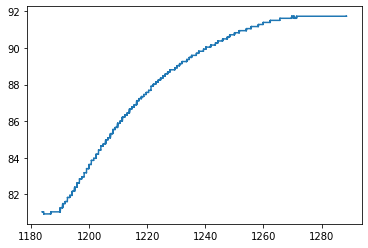

In [11]:
timeUp = [x.time for x in spike[1:maxTempIndex]]
tempUp = [x.motorTemp for x in spike[1:maxTempIndex]]
plt.plot(timeUp, tempUp)

-0.014860646645718381 111.23554056288984 -0.9954965605355924 0.0 7.490278929263966e-06


[]

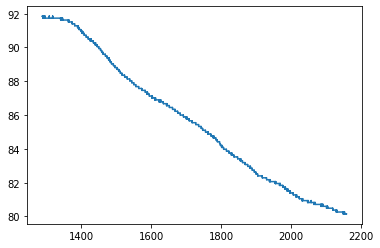

In [12]:
timeDown = [x.time for x in spike[maxTempIndex:-1]]
tempDown = [x.motorTemp for x in spike[maxTempIndex:-1]]
plt.plot(timeDown, tempDown)

import scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(timeDown, tempDown)
print(slope, intercept, r_value, p_value, std_err)

plt.plot()